# LS GAN

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a1bf33f582f3a7072a5a11cefc541e87b8017633bde1c6a9fe62ff25a79b7a3b
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
Note: you may need to restart the kernel to use updated packages.


MedNIST Dataset

100%|██████████| 82.8M/82.8M [00:04<00:00, 17.9MB/s]


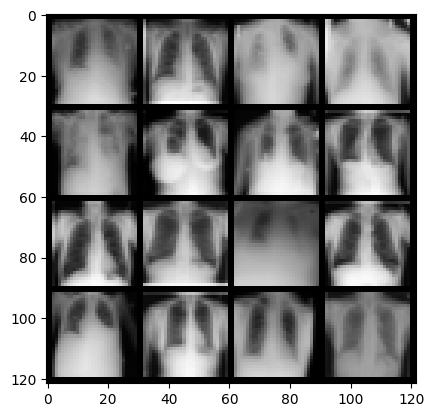

In [4]:
from medmnist import ChestMNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ChestMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Check sample images
sample = next(iter(dataloader))[0][:16]  # Take first 16 images
grid_img = torchvision.utils.make_grid(sample, nrow=4, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),  # Output image size 28x28
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)  # Reshape to image


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [7]:
latent_dim = 100
lr = 0.0002
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

loss_fn = nn.MSELoss()  # Least Squares Loss


In [9]:
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_dim).to(device)
        fake_images = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        real_loss = loss_fn(discriminator(real_images), real_labels)
        fake_loss = loss_fn(discriminator(fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_loss_G = loss_fn(discriminator(fake_images), real_labels)  # Trick discriminator
        fake_loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {fake_loss_G.item():.4f}")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        torchvision.utils.save_image(fake_images[:16], f"ls-gan_epoch{epoch+1}.png", nrow=4, normalize=True)


Epoch [1/50] | D Loss: 0.0423 | G Loss: 0.5579
Epoch [2/50] | D Loss: 0.0574 | G Loss: 1.0588
Epoch [3/50] | D Loss: 0.0591 | G Loss: 2.2991
Epoch [4/50] | D Loss: 0.1701 | G Loss: 1.1485
Epoch [5/50] | D Loss: 0.1394 | G Loss: 1.9688
Epoch [6/50] | D Loss: 0.2302 | G Loss: 1.7004
Epoch [7/50] | D Loss: 0.1434 | G Loss: 1.2358
Epoch [8/50] | D Loss: 0.1063 | G Loss: 1.5827
Epoch [9/50] | D Loss: 0.1474 | G Loss: 1.1530
Epoch [10/50] | D Loss: 0.2277 | G Loss: 1.1191
Epoch [11/50] | D Loss: 0.2020 | G Loss: 1.6982
Epoch [12/50] | D Loss: 0.2153 | G Loss: 1.3781
Epoch [13/50] | D Loss: 0.2343 | G Loss: 0.8150
Epoch [14/50] | D Loss: 0.2235 | G Loss: 1.1109
Epoch [15/50] | D Loss: 0.2083 | G Loss: 0.9643
Epoch [16/50] | D Loss: 0.2892 | G Loss: 1.0361
Epoch [17/50] | D Loss: 0.2513 | G Loss: 0.7649
Epoch [18/50] | D Loss: 0.2235 | G Loss: 0.7731
Epoch [19/50] | D Loss: 0.2038 | G Loss: 0.5928
Epoch [20/50] | D Loss: 0.2338 | G Loss: 0.5953
Epoch [21/50] | D Loss: 0.2427 | G Loss: 0.9692
E

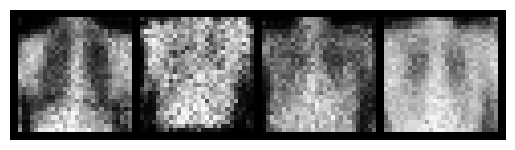

In [10]:
# Load and display generated images
img = plt.imread(f"ls-gan_epoch50.png")
plt.imshow(img)
plt.axis("off")
plt.show()


In [11]:
pip install torch torchvision scipy tqdm

Note: you may need to restart the kernel to use updated packages.


In [19]:
import torch
import numpy as np
import torch.nn.functional as F
from scipy.stats import entropy
from torchvision.models import inception_v3

# Load InceptionV3 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(weights="Inception_V3_Weights.DEFAULT", transform_input=False).to(device)
inception_model.eval()

def get_pred(x):
    """Compute softmax probabilities from InceptionV3."""
    with torch.no_grad():
        if x.shape[1] == 1:  # Convert grayscale to 3-channel
            x = x.repeat(1, 3, 1, 1)
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)  # Resize to 299x299
        x = inception_model(x)
        return F.softmax(x, dim=1).cpu().numpy()

def inception_score(images, batch_size=32, splits=10):
    """Compute Inception Score (IS)."""
    preds = np.zeros((len(images), 1000))  # Inception outputs 1000 classes

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size].to(device)
        preds[i:i + batch_size] = get_pred(batch)  # Get predictions

    split_scores = []
    for k in np.array_split(preds, splits):
        p_yx = np.mean(k, axis=0)  # Compute mean probability distribution
        p_yx = np.clip(p_yx, 1e-10, 1.0)  # Avoid log(0) issues
        k = np.clip(k, 1e-10, 1.0)  # Avoid log(0) issues
        kl_div = k * (np.log(k) - np.log(p_yx))  # Compute KL divergence
        split_scores.append(np.sum(kl_div, axis=1).mean())  # Mean KL divergence

    return np.exp(np.mean(split_scores))  # Final IS score

# Example: Compute IS for generated images
fake_images = torch.randn(100, 1, 64, 64)  # Example 100 grayscale images (1 channel, 64x64)
is_score = inception_score(fake_images)
print(f"Inception Score: {is_score:.4f}")


Inception Score: 1.2089


In [17]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_fid(real_images, fake_images):
    # Convert grayscale (1 channel) to RGB (3 channels)
    if real_images.shape[1] == 1:
        real_images = real_images.repeat(1, 3, 1, 1)
    if fake_images.shape[1] == 1:
        fake_images = fake_images.repeat(1, 3, 1, 1)

    real_images = real_images.view(real_images.size(0), -1).detach().cpu().numpy()
    fake_images = fake_images.view(fake_images.size(0), -1).detach().cpu().numpy()

    mu_real, sigma_real = np.mean(real_images, axis=0), np.cov(real_images, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_images, axis=0), np.cov(fake_images, rowvar=False)

    fid_matrix = sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake)
    fid_score = np.linalg.norm(mu_real - mu_fake) + np.trace(fid_matrix)

    # Ensure FID is a real number
    return np.real(fid_score)

# Example usage:
fid_score = calculate_fid(real_images, fake_images)
print(f"FID Score: {fid_score:.4f}")


FID Score: 266.3958


In [14]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Training logic (same as before)
        pass

    # Log losses and generated images
    writer.add_scalar("Loss/Generator", fake_loss_G.item(), epoch)
    writer.add_scalar("Loss/Discriminator", d_loss.item(), epoch)

    # Save and log generated images
    z = torch.randn(16, 100).to(device)
    fake_images = generator(z)
    writer.add_image("Generated Images", torchvision.utils.make_grid(fake_images, nrow=4, normalize=True), epoch)

writer.close()


In [21]:
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

# Define the log directory
log_dir = "./runs/experiment_1"

# Start TensorBoard
notebook.start("--logdir " + log_dir)


<IPython.core.display.Javascript object>

In [22]:
%load_ext tensorboard
%tensorboard --logdir ./runs


<IPython.core.display.Javascript object>

In [23]:
!zip -r tensorboard_logs.zip ./runs


  adding: runs/ (stored 0%)
  adding: runs/Mar29_06-40-18_b3f998016aa6/ (stored 0%)
  adding: runs/Mar29_06-40-18_b3f998016aa6/events.out.tfevents.1743230418.b3f998016aa6.31.0 (deflated 5%)
